# Sentiment analysis using BERT 

In [1]:
!pip install tqdm  

In [2]:
!pip install tensorflow-gpu 

In [3]:
!pip install --upgrade grpcio 

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.31.0)


In [4]:
!pip install bert-for-tf2 

In [5]:
!pip install sentencepiece 

# Essential modules to be imported

In [57]:
import os 
import math
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow import keras 
import seaborn as sns
from sklearn.model_selection import train_test_split
import re 
from sklearn.metrics import classification_report
import keras.backend as K


## BERT modules 

In [ ]:
import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

# Read data from my drive

In [7]:
train = pd.read_csv('/content/drive/My Drive/parto tech/sentiment_analysis/twitter/train.csv')
test = pd.read_csv('/content/drive/My Drive/parto tech/sentiment_analysis/twitter/test.csv')
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)


# Defining preprocessing functions to remove user metions, tags, single characters and multiple spaces

In [41]:
def remove_at_and_hashtag (tweet) :
  tweet = tweet.replace('@user',' ')
  return tweet.replace('#',' ')

def data_processing(tweet): 
  # remove user mentions and tags
  sentence = remove_at_and_hashtag(tweet)
  
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

In [42]:
train['tweet'] = train['tweet'].apply(data_processing)

# Plotting data to distinguish data balance.

## Due to figure below this is unbalanced dataFrame.


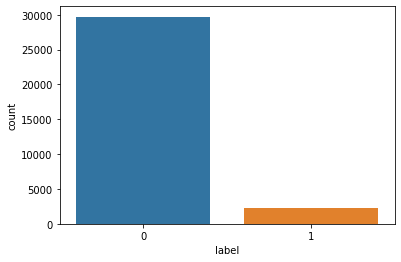

In [8]:
sns.countplot(train.label)

# In the four cells below I have downloaded uncased_L-12_H-768_A-12 version of BERT word embedding, unzip and moving it to "model" folder .

In [9]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-08 08:53:43--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  66.5MB/s    in 5.8s    

2020-08-08 08:53:49 (66.5 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [10]:
!unzip uncased_L-12_H-768_A-12.zip.1

Archive:  uncased_L-12_H-768_A-12.zip.1
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [11]:
os.makedirs('model',exist_ok=True)

In [12]:
!mv uncased_L-12_H-768_A-12/ model

# Keep track of essential bert files in order to be used in my final model

In [13]:
bert_model_name = 'uncased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join('model/',bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir,'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir,'bert_config.json')

# Split train dataset to train and test . 
- train_data is 0.8 of whole data . train_data's shape is (25569,2)
- test_data is 0.2 of whole data . test_data's shape is (6394,2)



In [44]:
train_len = (len(train) // 10) * 8
train_data , test_data = train.loc[:train_len] , train.loc[train_len:]

# Create a class for tokenizing and padding the tweets

In [16]:
class TweetSentimentAnalysisData :
  DATA_COLUMN = 'tweet'
  LABEL_COLUMN = 'label'


  def __init__(self,train,test,tokenizer:FullTokenizer,max_seq_len=150) :
    self.train = train 
    self.test = test 
    self.tokenizer = tokenizer 
    self.max_seq_len = 0 

    ((self.x_train,self.y_train),(self.x_test,self.y_test)) = map(self._prepare,[train,test])
    self.max_seq_len = min(self.max_seq_len,max_seq_len)
    self.x_train,self.x_test = map(self._padding,[self.x_train,self.x_test ])


  def _prepare(self,df) :
    x,y = [],[] 

    for _ , row in tqdm(df.iterrows()) :
      tweet , label = row[TweetSentimentAnalysisData.DATA_COLUMN] , row[TweetSentimentAnalysisData.LABEL_COLUMN] 

      tokens = self.tokenizer.tokenize(tweet)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]

      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

      self.max_seq_len = max(self.max_seq_len,len(token_ids)) 

      x.append(token_ids) 
      y.append(label)

    return np.array(x) , np.array(y)
  

  def _padding(self,ids) :
    x = [] 
    
    for input_ids in ids :
      cut_point = min(len(input_ids),self.max_seq_len-2)
      input_ids = input_ids[:cut_point]
      input_ids = input_ids + [0]* (self.max_seq_len-len(input_ids))
      x.append(np.array(input_ids))


    return np.array(x)

# Create a tokenizer using BERT

In [17]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir,'vocab.txt'))

# Apply TweetSentimentAnalysis class to train_data and test_data 

In [46]:
data = TweetSentimentAnalysisData(train_data,test_data,tokenizer,max_seq_len=150)

25569it [00:13, 1958.27it/s]
6394it [00:03, 1990.94it/s]


# Designing and building the architecture of neural net and take a look at net's summary

In [20]:
def create_model (max_seq_len,bert_config_file,bert_ckpt_file) :
  with tf.io.gfile.GFile(bert_config_file,'r') as reader :
    bert_config = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bert_config)
    bert_params.adapter_size = None 
    bert = BertModelLayer.from_params(bert_params,name='bert')


  input_ids = keras.layers.Input(shape=(max_seq_len,),dtype='int32',name ='input_ids') 
  bert_output = bert(input_ids)
  print(bert_output.shape)
  cls_out = keras.layers.Lambda(lambda seq : seq[:,0,:])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(768,activation='tanh')(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(1,activation='sigmoid')(logits)


  model = keras.Model(inputs=input_ids,outputs=logits)
  model.build(input_shape=(None,max_seq_len))

  load_stock_weights(bert,bert_ckpt_file)

  return model 



In [50]:
model = create_model(data.max_seq_len,bert_config_file,bert_ckpt_file)

(None, 132, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2ab1dc5390> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [51]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 132)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 132, 768)          108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# I want to use f1-score as my NN metric param, so i copied this block of code from previous versions of keras

In [35]:
import keras.backend as K

def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Compiling model with Adam optimizer . using of Adam optimizer is suggested !

In [52]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = keras.losses.BinaryCrossentropy() ,
    metrics = [get_f1] ,
)

# As we see in previous cells this dataset is unbalanced thus I will pass weight of each class to my model. Below I've calculate the weights using sklearn

In [26]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=[0,1],y=train.label)
class_weights = dict(enumerate(class_weights))

In [27]:
class_weights

{0: 0.5377187079407806, 1: 7.128010704727921}

# Fitting the model for 5 epochs

In [53]:
model.fit(
    x=data.x_train ,
    y=data.y_train ,
    validation_split=0.1 ,
    batch_size = 16 ,
    shuffle = True ,
    epochs = 5 ,
    class_weight = class_weights
)

Epoch 1/5
1439/1439 [==============================] - 1575s 1s/step - loss: 0.4866 - get_f1: 0.3000 - val_loss: 0.2760 - val_get_f1: 0.4043
Epoch 2/5
1439/1439 [==============================] - 1565s 1s/step - loss: 0.2238 - get_f1: 0.4743 - val_loss: 0.2061 - val_get_f1: 0.4559
Epoch 3/5
1439/1439 [==============================] - 1566s 1s/step - loss: 0.1262 - get_f1: 0.5346 - val_loss: 0.2355 - val_get_f1: 0.4485
Epoch 4/5
1439/1439 [==============================] - 1568s 1s/step - loss: 0.0816 - get_f1: 0.5909 - val_loss: 0.2454 - val_get_f1: 0.4536
Epoch 5/5
1439/1439 [==============================] - 1571s 1s/step - loss: 0.0542 - get_f1: 0.6139 - val_loss: 0.1629 - val_get_f1: 0.5093


In [55]:
y_pred = model.predict(data.x_test)

# Let's take a look at classification_report of our model !

In [56]:
print(classification_report(data.y_test,K.round(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5950
           1       0.64      0.82      0.72       444

    accuracy                           0.96      6394
   macro avg       0.81      0.89      0.85      6394
weighted avg       0.96      0.96      0.96      6394



# Compared with word2vec using NN approach, f1-score of positive class (contains sexism or racism content) has been improved by 23% !!
# F1-score of negative class is still 98%

# Conclusion 
### By using BERT word embedding accuracy has imporved so much but it takes about one hour to learn because NN has more than 109 million trainable parameters